In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import pandas as pd
from PIL import Image

In [2]:
Adata = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
Adata

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [16]:
#max image size
height = 100
width = 100
data = []
labels = []
bboxes =[]
imagePaths=[]
path = "lib/datasets/LISA/"
test = 0
for i in range(len(Adata["Filename"])):
    file = Adata["Filename"][i]
    sign = Adata["Annotation tag"][i]
    image = Image.open(path+file)
    h, w = image.height,image.width
    image = image.resize((width,height))
    image = np.asarray(image)
    data.append(image)
    labels.append(sign)
    bboxes.append((float(Adata['Upper left corner X'][i])/w,float(Adata['Upper left corner Y'][i])/h,float(Adata['Lower right corner X'][i])/w,float(Adata['Lower right corner Y'][i])/h))

In [15]:
h,w

(480, 640)

In [4]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
split = train_test_split(data, labels, bboxes,test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]

In [6]:
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(100, 100, 3)))
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

In [7]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,outputs=(bboxHead, softmaxHead))

In [8]:
losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}
lossWeights = {"class_label": 1.0,"bounding_box": 1.0
}
opt = 'Adam'
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 100, 100, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 100, 100, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [9]:
trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes
}
testTargets = {"class_label": testLabels,"bounding_box": testBBoxes
}

In [10]:
H = model.fit(trainImages, trainTargets,validation_data=(testImages, testTargets),batch_size=32,epochs=30,verbose=1)

Epoch 1/30
197/197 [==============================] - 85s 429ms/step - loss: 2.7703 - bounding_box_loss: 0.0240 - class_label_loss: 2.7463 - bounding_box_accuracy: 0.7653 - class_label_accuracy: 0.2630 - val_loss: 2.3758 - val_bounding_box_loss: 0.0211 - val_class_label_loss: 2.3547 - val_bounding_box_accuracy: 0.7957 - val_class_label_accuracy: 0.4074
Epoch 2/30
197/197 [==============================] - 83s 420ms/step - loss: 2.2826 - bounding_box_loss: 0.0179 - class_label_loss: 2.2647 - bounding_box_accuracy: 0.8003 - class_label_accuracy: 0.3709 - val_loss: 1.8851 - val_bounding_box_loss: 0.0185 - val_class_label_loss: 1.8665 - val_bounding_box_accuracy: 0.8199 - val_class_label_accuracy: 0.5016
Epoch 3/30
197/197 [==============================] - 83s 424ms/step - loss: 1.9975 - bounding_box_loss: 0.0154 - class_label_loss: 1.9820 - bounding_box_accuracy: 0.8208 - class_label_accuracy: 0.4449 - val_loss: 1.5691 - val_bounding_box_loss: 0.0185 - val_class_label_loss: 1.5506 - val_

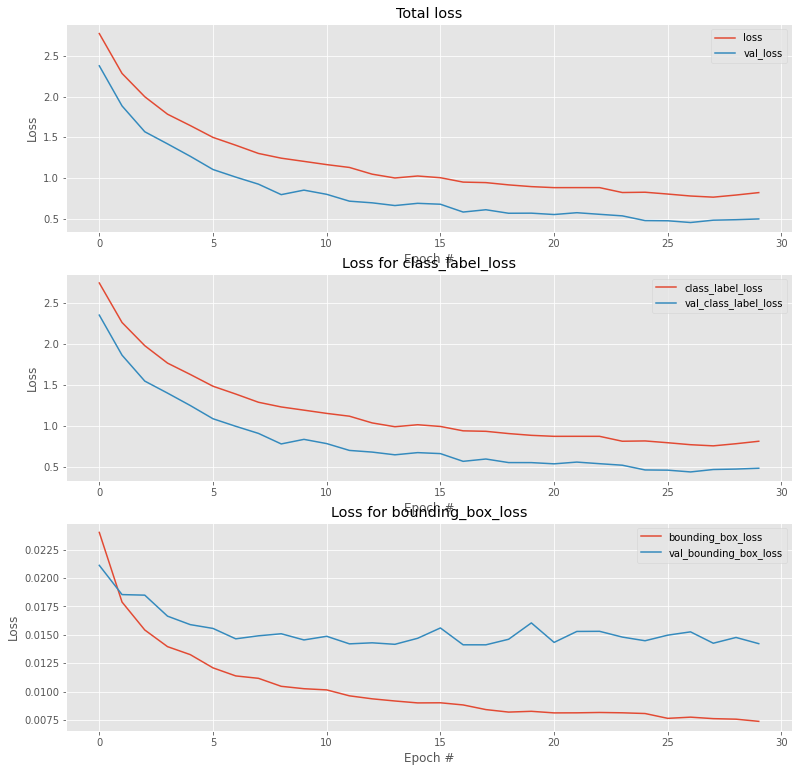

In [12]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0,30)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

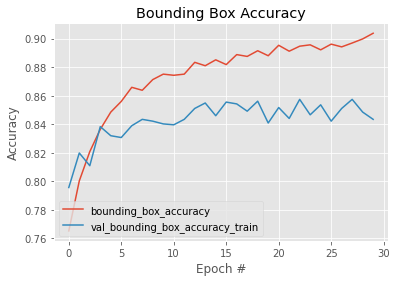

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy_train")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

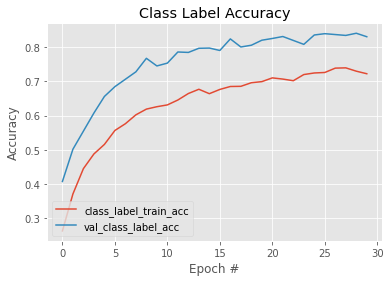

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")